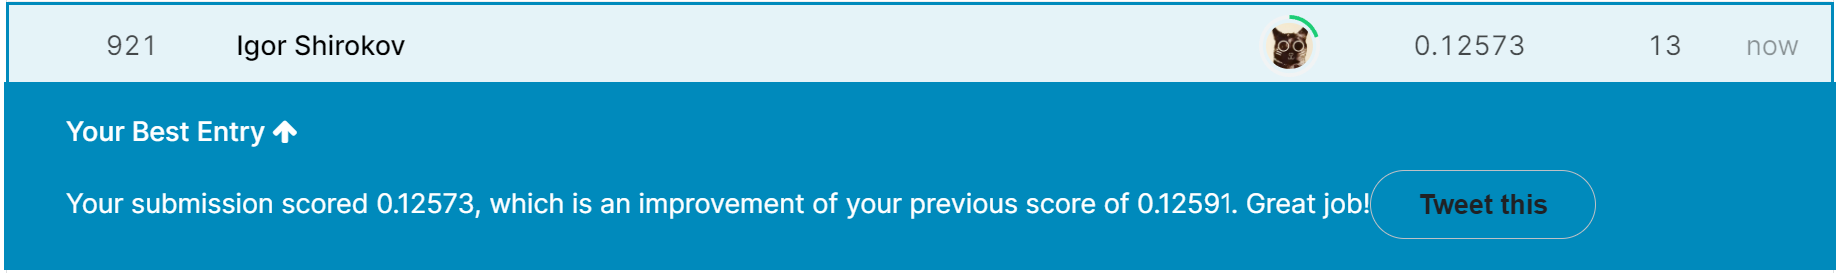

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor

from scipy.stats import norm, lognorm, johnsonsu

from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.decomposition import PCA
# from scipy.stats import zscore, skew

# Import Data Sets

In [2]:
# Setting this option will print all collumns of a dataframe and all of the data in a feature
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# load train df
train = pd.read_csv('train.csv')
# Drop the  'Id' colum since it's unnecessary for the prediction process
train.drop(['Id'], axis=1, inplace=True)

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Preprocessing

# Exploratory Data Analysis

In [5]:
# Some NaN have explanation in the File description. Let's define them
def replace_func_1(df):
    return df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                 50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                 80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                 150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "Alley" : {np.nan : "No alley access"},
                       "BsmtQual" : {np.nan : "No Basement"},
                       "BsmtCond" : {np.nan : "No Basement"},
                       "BsmtFinType1" : {np.nan : "No Basement"},
                       "BsmtFinType2" : {np.nan : "No Basement"},
                       "BsmtExposure" : {np.nan : "No Basement"},
                       "FireplaceQu" : {np.nan : "No Fireplace"},
                       "GarageType" : {np.nan : "No Garage"},
                       "GarageYrBlt" : {np.nan : 1900},
                       "GarageFinish" : {np.nan : "No Garage"},
                       "GarageQual" : {np.nan : "No Garage"},
                       "GarageCond" : {np.nan : "No Garage"},
                       "PoolQC" : {np.nan : "No Pool"},
                       "Fence" : {np.nan : "No Fence"},
                       "MiscFeature" : {np.nan : "None"},
    })

train = replace_func_1(train)

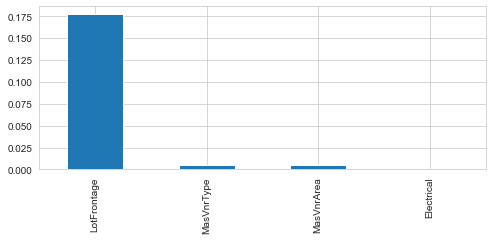

In [6]:
# Show NaN as % of missing values in the column
plt.figure(figsize=(8,3))
sns.set_style("whitegrid")
is_null_list = train.isnull().sum() / len(train)
is_null_list.sort_values(ascending=False, inplace=True)
is_null_list[is_null_list > 0].plot.bar()
plt.show()

In [7]:
train.groupby('MasVnrType', dropna=False).median()['MasVnrArea']

MasVnrType
BrkCmn     192.0
BrkFace    202.0
None         0.0
Stone      206.5
NaN          NaN
Name: MasVnrArea, dtype: float64

In [8]:
# Find how OverallQual corr OverallQual
LotFrontage_median = train.groupby('OverallQual').median()['LotFrontage']
LotFrontage_median

OverallQual
1      50.0
2      51.0
3      60.0
4      60.0
5      67.0
6      69.0
7      68.0
8      79.5
9      85.5
10    103.0
Name: LotFrontage, dtype: float64

In [9]:
train.groupby('Electrical', dropna=False).median()['SalePrice']

Electrical
FuseA    121250.0
FuseF    115000.0
FuseP     82000.0
Mix       67000.0
SBrkr    170000.0
NaN      167500.0
Name: SalePrice, dtype: float64

In [10]:
bins = np.linspace(min(train['SalePrice']), max(train['SalePrice']), 10)
train.groupby([pd.cut(train.SalePrice, bins),'Electrical']).median()['OverallQual']

SalePrice                 Electrical
(34900.0, 114911.111]     FuseA          5.0
                          FuseF          4.0
                          FuseP          4.5
                          Mix            5.0
                          SBrkr          5.0
(114911.111, 194922.222]  FuseA          5.0
                          FuseF          6.0
                          FuseP          6.0
                          Mix            NaN
                          SBrkr          6.0
(194922.222, 274933.333]  FuseA          6.0
                          FuseF          NaN
                          FuseP          NaN
                          Mix            NaN
                          SBrkr          7.0
(274933.333, 354944.444]  FuseA          NaN
                          FuseF          NaN
                          FuseP          NaN
                          Mix            NaN
                          SBrkr          8.0
(354944.444, 434955.556]  FuseA          NaN
                  

In [11]:
# Fill other NaN
def replace_func_2(df):
    df = df.replace({"MasVnrType" : {np.nan : "None"},
                "MasVnrArea" : {np.nan : 0},
                "Electrical" : {np.nan : "SBrkr"}
               })
    for index, row in df.iterrows():
        if np.isnan(row['LotFrontage']):
            df.loc[index, 'LotFrontage'] = LotFrontage_median.iat[row['OverallQual'] - 1]
    return df

train = replace_func_2(train)

In [12]:
# Check NaN
train.isna().sum().sum()

0

In [13]:
# Combine Y and M
date_sold = train[["YrSold","MoSold"]].copy()
date_sold.columns=['year','month']
date_sold['day']=1
train['DATE'] = pd.to_datetime(date_sold)
train = train.drop(["YrSold","MoSold"], axis=1)
del date_sold

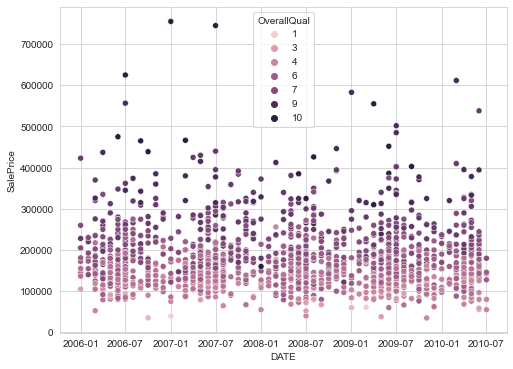

In [14]:
# Plot DATE
plt.figure(figsize=(8,6))
sns.scatterplot(y=train['SalePrice'], x=train['DATE'], hue=train['OverallQual'])
plt.show()

---

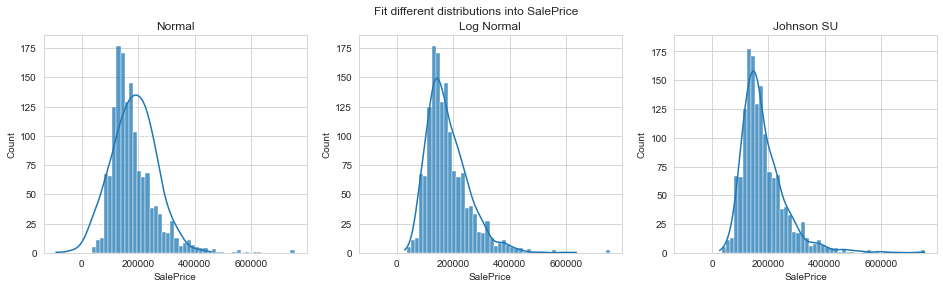

In [15]:
# FutureWarning: `distplot` is a deprecated function and will be removed in a future version.
# That's why let's use histplot without fit method
r_size=1500
y = train['SalePrice']
fig, axes = plt.subplots(1, 3, figsize=(16,4), sharex=True)
fig.suptitle('Fit different distributions into SalePrice')

# Normal
loc1, scale1 = norm.fit(y)
r1 = norm.rvs(loc1, scale1, size=r_size)
sns.histplot(data=r1, kde='True', ax=axes[0], alpha = 0)
sns.histplot(data=y, ax=axes[0])
axes[0].set_title('Normal')

# Log Normal
s1, loc2, scale2 = lognorm.fit(y)
r2 = lognorm.rvs(s1, loc2, scale2, size=r_size)
sns.histplot(data=r2, kde='True', ax=axes[1], alpha = 0)
sns.histplot(data=y, ax=axes[1])
axes[1].set_title('Log Normal')

# Johnson SU
a1, b1, loc3, scale3 = johnsonsu.fit(y)
r3 = johnsonsu.rvs(a1, b1, loc3, scale3, size=r_size)
sns.histplot(data=r3, kde='True', ax=axes[2], alpha = 0)
sns.histplot(data=y, ax=axes[2])
axes[2].set_title('Johnson SU')

plt.show()

In [16]:
# We use the numpy fuction log1p which applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

In [17]:
# Devide data to quantitative and qualitative
quantitative = list(train.describe(include=np.number).columns)
qualitative = list(train.describe(include=np.object_).columns)
# To discrete and continuous
quant_discrete = []
quant_continuous = []
for quant in quantitative:
    if len(np.unique(train[quant])) <=20:
        quant_discrete.append(quant)
    else:
        quant_continuous.append(quant)

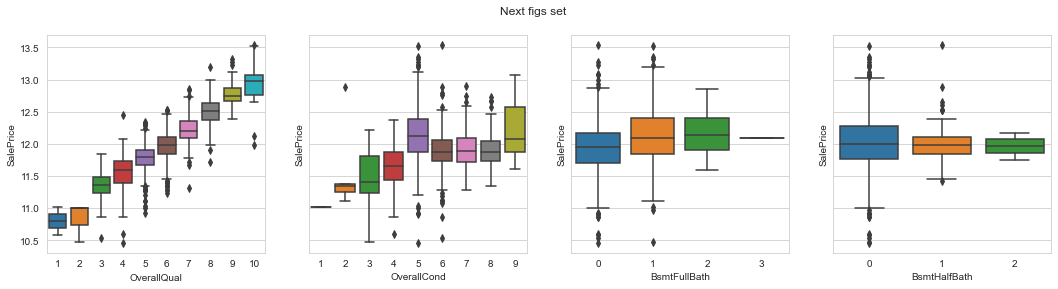

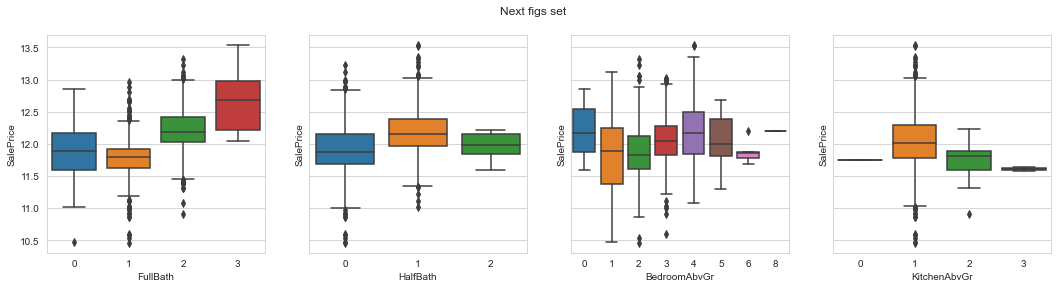

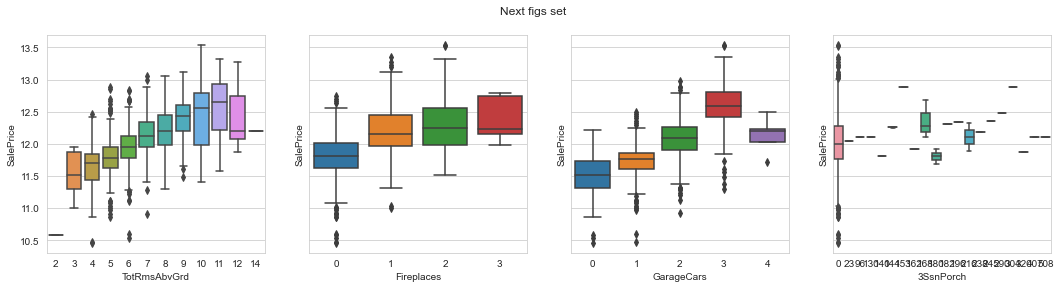

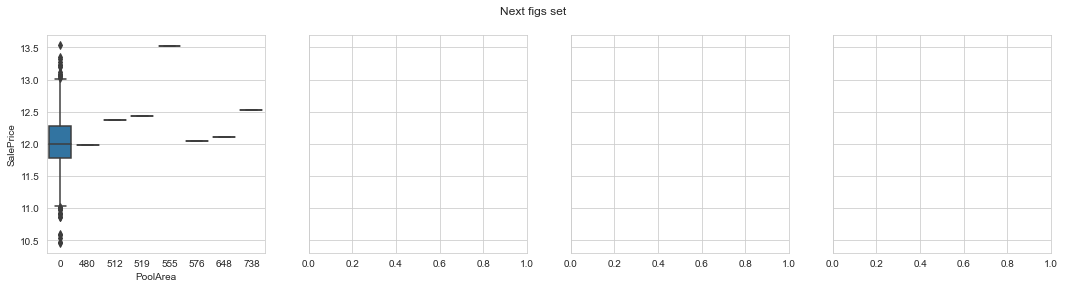

In [18]:
# Plot discret
i=0
while i < len(quant_discrete):
    fig, axes = plt.subplots(1, 4, figsize=(18,4), sharey=True)
    fig.suptitle('Next figs set')
    k=0
    for j in range(i,i+4):
        if j >= len(quant_discrete):
            break
        else:
            sns.boxplot(data=train, y='SalePrice', x=quant_discrete[j], ax=axes[k])
        k+=1
    i+=4
    plt.show()

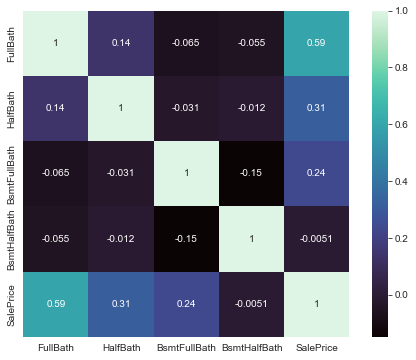

In [19]:
# See how SalePrice correlated with different batches
plt.figure(figsize=(8,6))
banch = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']
corr_table = train[[*banch, 'SalePrice']].corr()
sns.heatmap(corr_table, square=True, annot=True, cmap='mako')
plt.show()

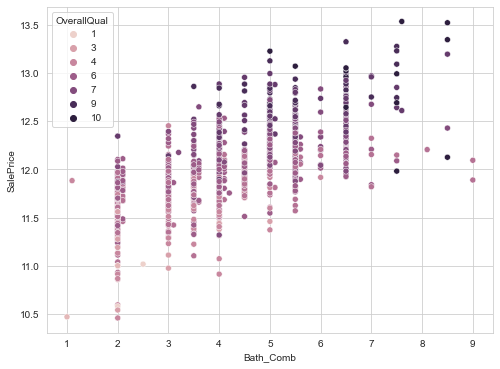

In [20]:
# Create Bath_Comb feature and plot it
coff = [2, 1.5, 1, 0.1]
train['Bath_Comb'] = (train.loc[:, banch] * np.array(coff)).sum(axis=1)

# Plot Bath_Comb
plt.figure(figsize=(8,6))
sns.scatterplot(y=train['SalePrice'], x=train['Bath_Comb'], hue=train['OverallQual'])
plt.show()

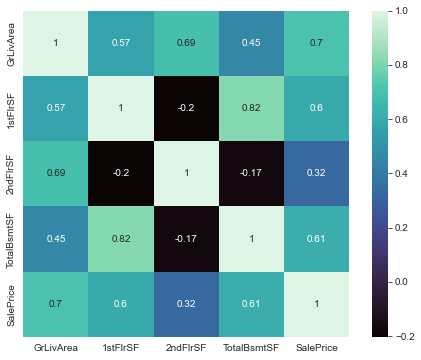

In [21]:
# See how SalePrice correlated with different batches
plt.figure(figsize=(8,6))
banch = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']
corr_table = train[[*banch, 'SalePrice']].corr()
sns.heatmap(corr_table, square=True, annot=True, cmap='mako')
plt.show()

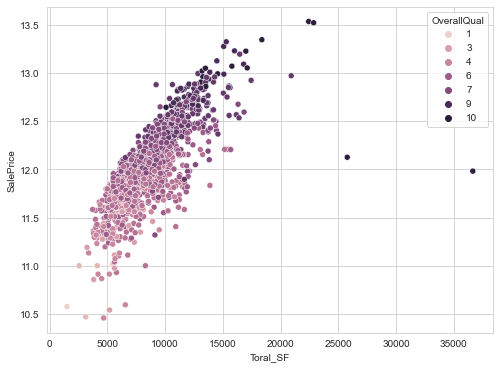

In [22]:
# Create Toral_SF feature and plot it
coff = [2.5, 2, 1, 2]
train['Toral_SF'] = (train.loc[:, banch] * np.array(coff)).sum(axis=1)

# Plot Toral_SF
plt.figure(figsize=(8,6))
sns.scatterplot(y=train['SalePrice'], x=train['Toral_SF'], hue=train['OverallQual'])
plt.show()

In [23]:
train["Toral_SF"] = np.log1p(train["Toral_SF"])

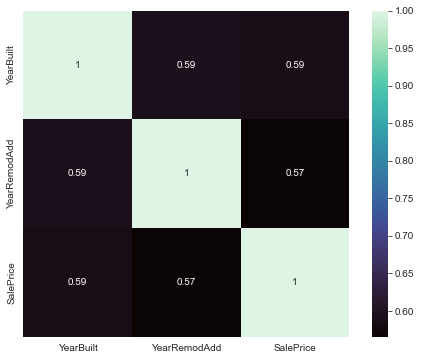

In [24]:
# See how SalePrice correlated with different batches
plt.figure(figsize=(8,6))
banch = ['YearBuilt', 'YearRemodAdd']
corr_table = train[[*banch, 'SalePrice']].corr()
sns.heatmap(corr_table, square=True, annot=True, cmap='mako')
plt.show()

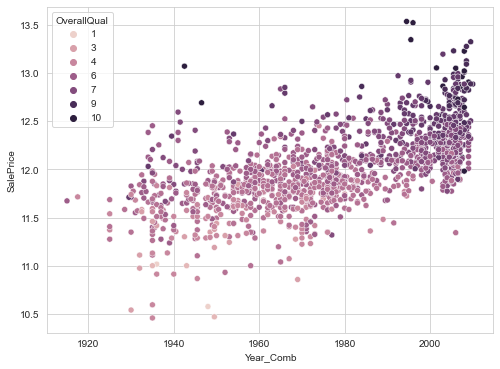

In [25]:
# Create Year_Comb feature and plot it
coff = [0.5, 0.5]
train['Year_Comb'] = (train.loc[:, banch] * np.array(coff)).sum(axis=1)

# Plot Bath_Comb
plt.figure(figsize=(8,6))
sns.scatterplot(y=train['SalePrice'], x=train['Year_Comb'], hue=train['OverallQual'])
plt.show()

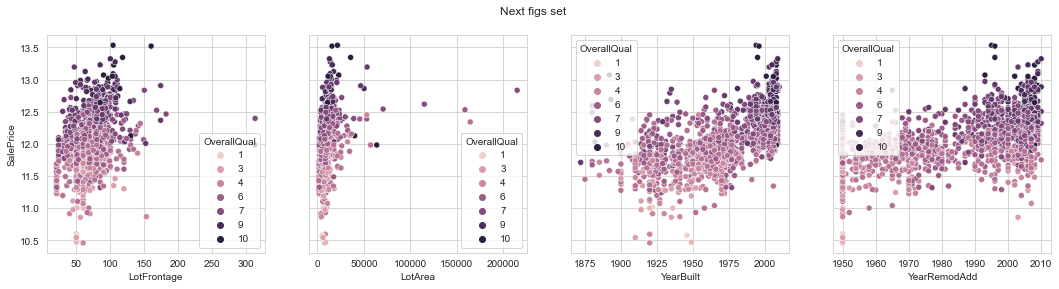

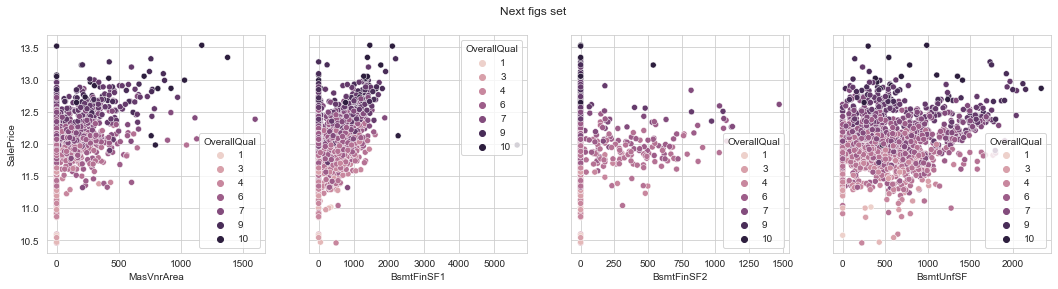

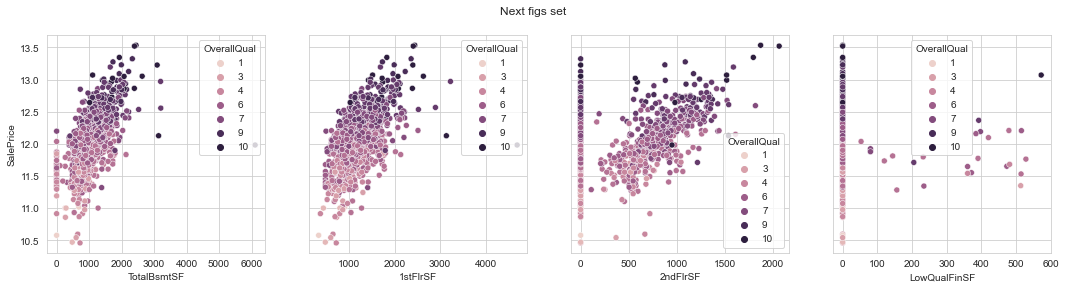

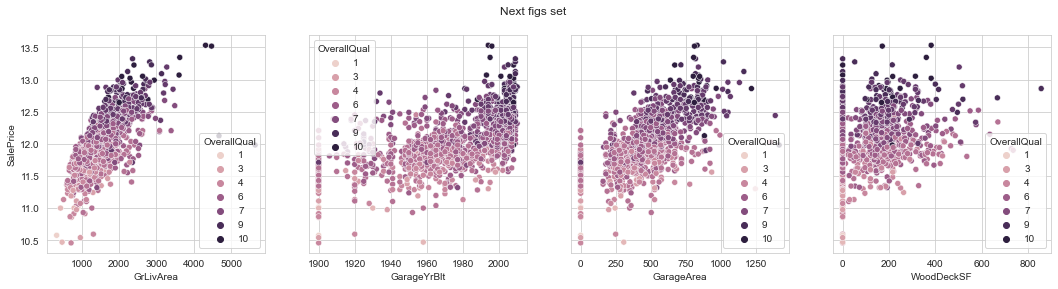

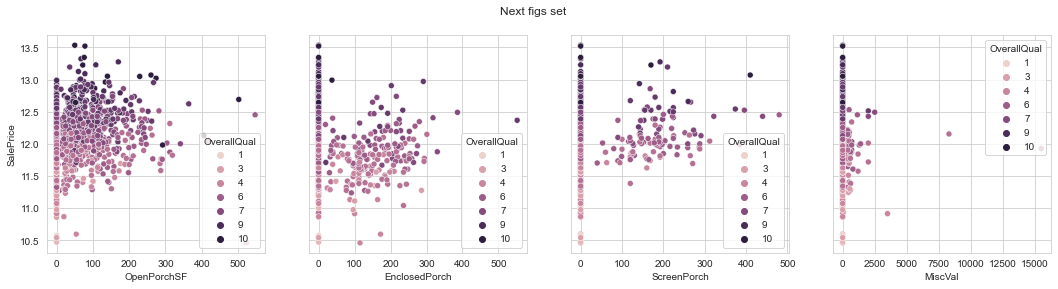

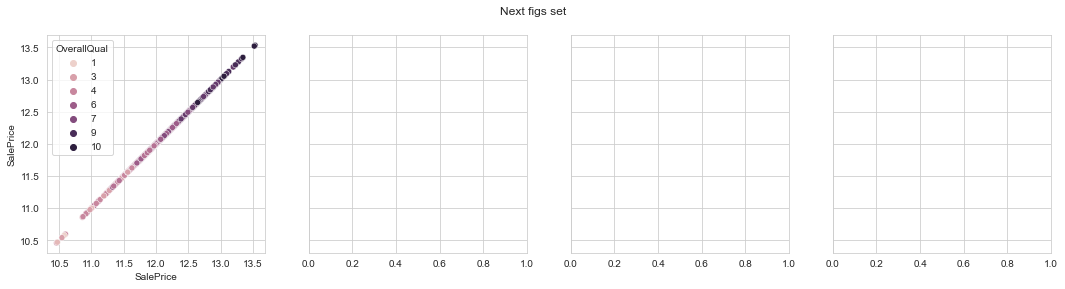

In [26]:
# Plot continuous
i=0
while i < len(quant_continuous):
    fig, axes = plt.subplots(1, 4, figsize=(18,4), sharey=True)
    fig.suptitle('Next figs set')
    k=0
    for j in range(i,i+4):
        if j >= len(quant_continuous):
            break
        else:
            sns.scatterplot(data=train, y='SalePrice', x=quant_continuous[j], hue='OverallQual', ax=axes[k])
        k+=1
    i+=4
    plt.show()

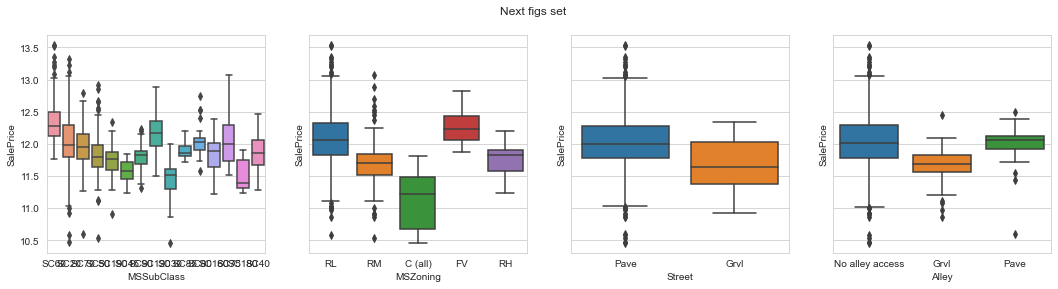

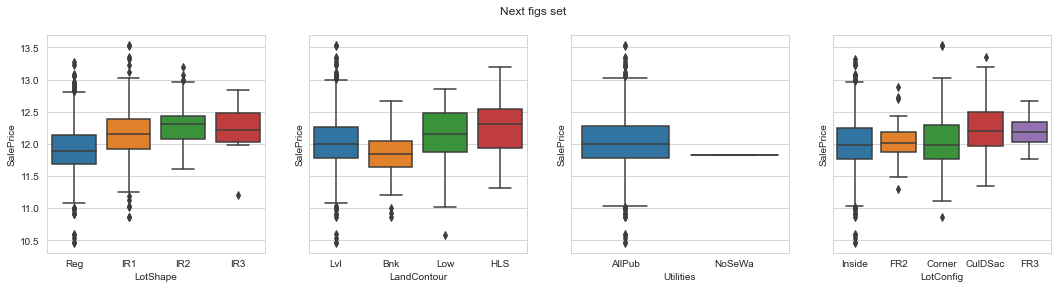

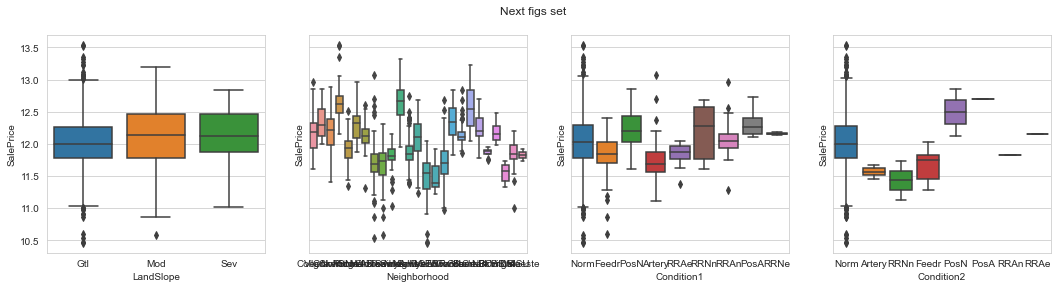

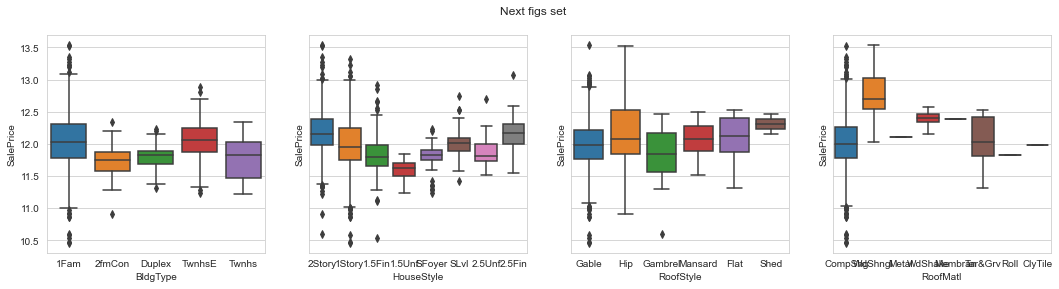

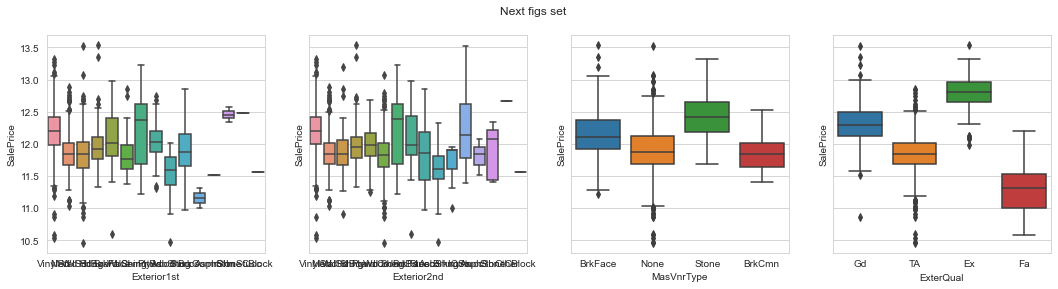

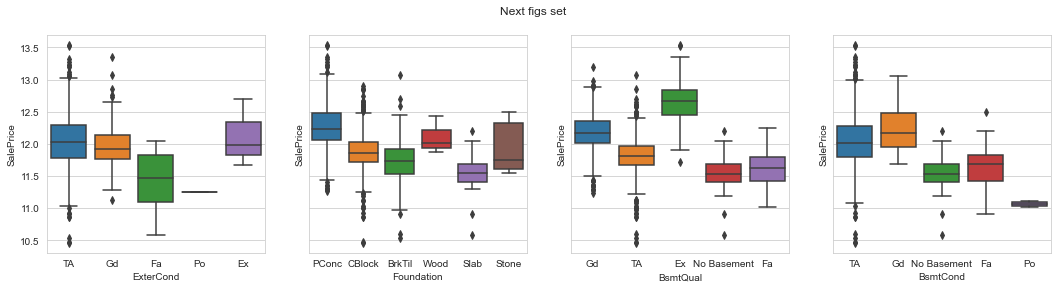

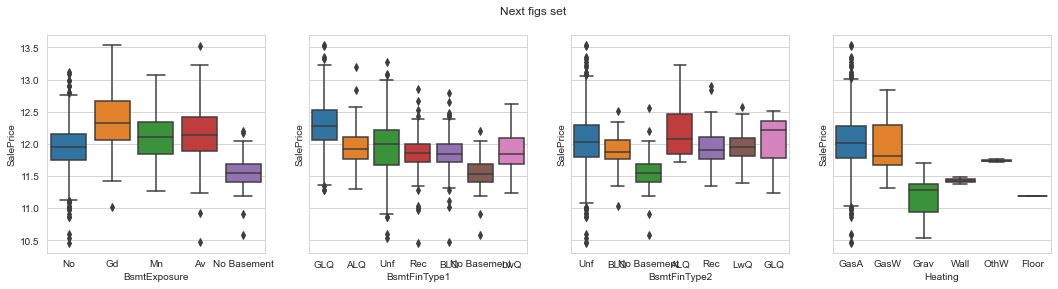

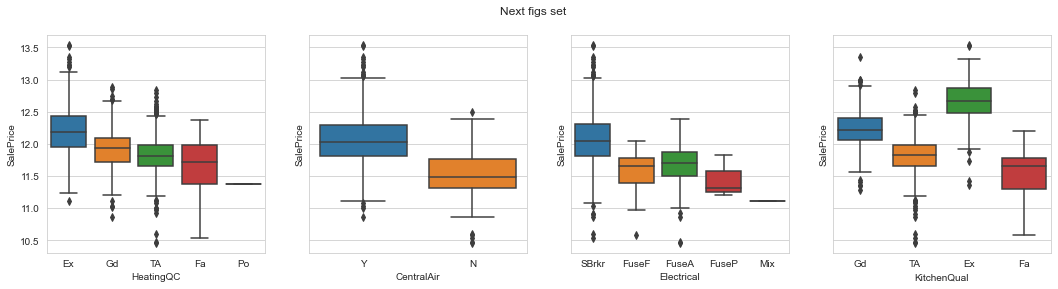

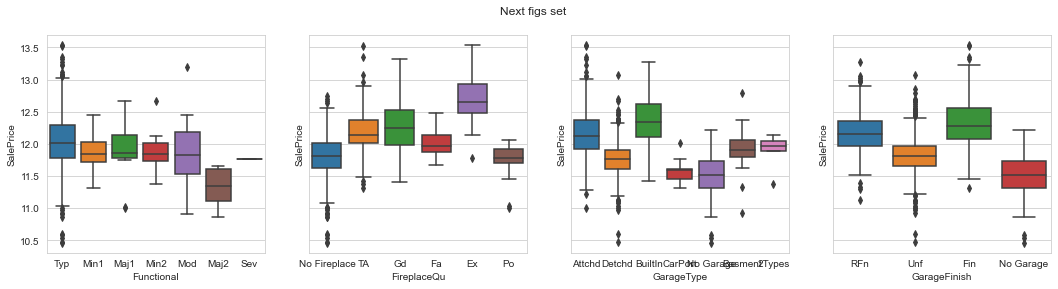

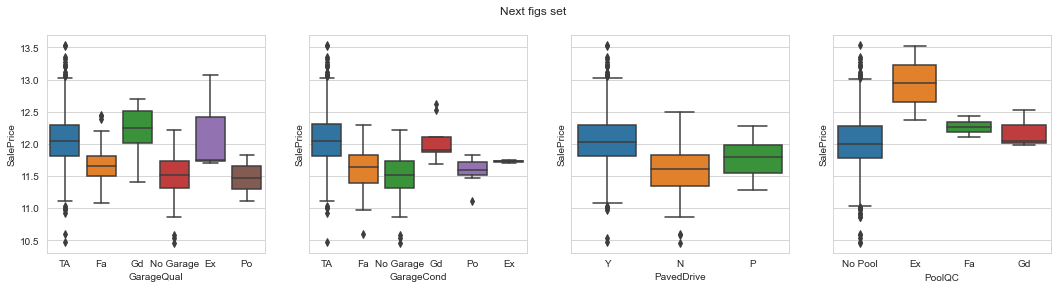

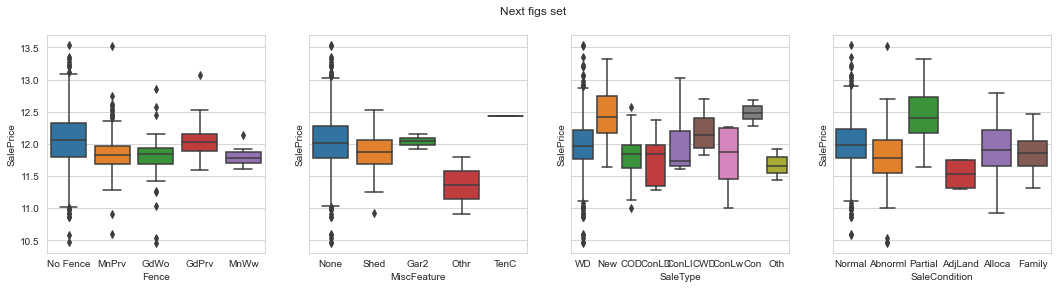

In [27]:
# Plot qualitative
i=0
while i < len(qualitative):
    fig, axes = plt.subplots(1, 4, figsize=(18,4), sharey=True)
    fig.suptitle('Next figs set')
    k=0
    for j in range(i,i+4):
        if j >= len(qualitative):
            break
        else:
            sns.boxplot(data=train, y='SalePrice', x=qualitative[j], ax=axes[k])
        k+=1
    i+=4
    plt.show()

## Сonclusions 1
* 3SsnPorch: drop
* PoolArea: drop
* YrSold: drop
* MoSold: drop


* Fireplaces: >0 or not


* 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath': combine
* 'GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF' : combine
* 'YearBuilt', 'YearRemodAdd' : combine

## Сonclusions 2

* BsmtFinSF1: drop
* BsmtFinSF2: drop
* LowQualFinSF: drop
* WoodDeckSF: drop
* MiscVal: drop


* LotArea: drop >100000


* EnclosedPorch: >0 or not
* ScreenPorch: >0 or not
* OpenPorchSF: >0 or not


* BsmtUnfSF: bins [0, 500, 1000, 1500, 5000]

## Сonclusions 3
* Street: drop
* Utilities: drop
* LotConfig: drop
* LandSlope: drop
* BldgType drop
* RoofStyle: drop
* RoofMatl: drop
* Exterior1st: drop
* Exterior2st: drop
* GarageYrBlt: drop
* Fence: drop
* MiscFeature: drop
* SaleCondition: drop
* BsmtExposure: drop


* MSZoning: Commercial or not
* LotShape: IR2, IR3 (Irregular) or not
* Heating: Grav or not
* SaleType: New or not


* Condition1 + Condition2: PosN or PosA, Artery, Other

In [28]:
def EDA_func(df):
    # Create group_BsmtUnfSF
    bins = [-1, 500, 1000, 1500, 5000]
    labels = [0, 1, 2, 3]
    df['group_BsmtUnfSF'] = pd.cut(df.BsmtUnfSF, bins=bins, labels=labels).copy()
    
    for index, row in df.iterrows():
        
        # Fireplaces
        if row['Fireplaces'] > 0:
            df.loc[index, 'have_Fireplace'] = 1
        else:
            df.loc[index, 'have_Fireplace'] = 0
            
        # EnclosedPorch
        if row['EnclosedPorch'] > 0:
            df.loc[index, 'have_EnclosedPorch'] = 1
        else:
            df.loc[index, 'have_EnclosedPorch'] = 0
            
        # ScreenPorch
        if row['ScreenPorch'] > 0:
            df.loc[index, 'have_ScreenPorch'] = 1
        else:
            df.loc[index, 'have_ScreenPorch'] = 0
            
        # OpenPorchSF
        if row['ScreenPorch'] > 0:
            df.loc[index, 'have_OpenPorchSF'] = 1
        else:
            df.loc[index, 'have_OpenPorchSF'] = 0

        # MSZoning
        if row['MSZoning'] == "C (all)":
            df.loc[index, 'commercial_MSZoning'] = 1
        else:
            df.loc[index, 'commercial_MSZoning'] = 0
            
        # ScreenPorch
        if row['LotShape'] in ['IR2', 'IR3']:
            df.loc[index, 'Irregular_LotShape'] = 1
        else:
            df.loc[index, 'Irregular_LotShape'] = 0

        # Heating
        if row['Heating'] == "Grav":
            df.loc[index, 'Grav_Heating'] = 1
        else:
            df.loc[index, 'Grav_Heating'] = 0
            
        # SaleType
        if row['SaleType'] == "New":
            df.loc[index, 'new_home_SaleType'] = 1
        else:
            df.loc[index, 'new_home_SaleType'] = 0
        
        # Condition1 + Condition2
        if (row['Condition1'] == ("PosN" or "PosA")) | (row['Condition2'] == ("PosN" or "PosA")):
            df.loc[index, 'Condition_comb'] = 2
        elif (row['Condition1'] == "Artery") | (row['Condition2'] == "Artery"):
            df.loc[index, 'Condition_comb'] = 0
        else:
            df.loc[index, 'Condition_comb'] = 1

    return df

# Model Development | Preparations

In [29]:
# load df's
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Drop the  'Id' colum since it's unnecessary for the prediction process
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [30]:
# We use the numpy fuction log1p which applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

In [31]:
# Mean and std for OverallQual groups
OQual_SP_std = []
OQual_SP_mean = []
for i in range(10):
    OQual_SP_std.append(np.std(train[train['OverallQual']==i+1]['SalePrice']))
    OQual_SP_mean.append(np.mean(train[train['OverallQual']==i+1]['SalePrice']))
    
# Drop rows where value exceed 3*std
for index, row in train.iterrows():
    if (row['SalePrice'] > OQual_SP_mean[row['OverallQual']-1] + 3*OQual_SP_std[row['OverallQual']-1]) | (row['SalePrice'] < OQual_SP_mean[row['OverallQual']-1] - 3*OQual_SP_std[row['OverallQual']-1]):
        train.drop(index, inplace=True)

In [32]:
# Define features and target variable
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop('SalePrice', axis=1)
test_features = test
features = train_features.append(test_features, sort=False)

In [33]:
features = replace_func_1(features)
features = replace_func_2(features)

In [34]:
# Fill NaN
quantitative = list(features.describe(include=np.number).columns)
qualitative = list(test.describe(include=np.object_).columns)
features[quantitative] = features[quantitative].apply(lambda x: x.fillna(x.median()),axis=0)
features[qualitative] = features[qualitative].apply(lambda x: x.fillna("None"),axis=0)

In [35]:
# Preparations
banch = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']
coff = [2, 1.5, 1, 0.1]
features['Bath_Comb'] = (features.loc[:, banch] * np.array(coff)).sum(axis=1)

banch = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']
coff = [2.5, 2, 1, 2]
features['Toral_SF'] = (features.loc[:, banch] * np.array(coff)).sum(axis=1)

banch = ['YearBuilt', 'YearRemodAdd']
coff = [0.5, 0.5]
features['Year_Comb'] = (features.loc[:, banch] * np.array(coff)).sum(axis=1)

In [36]:
features = EDA_func(features)

In [37]:
# Check NaN
features.isna().sum().sum()

0

In [38]:
# Drop lists of features that we don't need
drop_list_1 = ['3SsnPorch', 'PoolArea', 'YrSold', 'MoSold', 'MiscVal']
drop_list_2 = ['BsmtFinSF1', 'BsmtFinSF2', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF']
drop_list_3 = ['Street', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'GarageYrBlt', 'Fence', 'MiscFeature', 'SaleCondition', 'BsmtExposure']
drop_list_4 = ['Fireplaces', 'EnclosedPorch', 'ScreenPorch', 'MSZoning', 'LotShape', 'Heating', 'SaleType', 'BsmtUnfSF', 'Condition1', 'Condition2']
drop_list_5 = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']

In [39]:
drop_list_full = drop_list_1+drop_list_2+drop_list_3+drop_list_4+drop_list_5

In [40]:
features = features.drop(drop_list_full, axis=1)

In [41]:
features.head()

,MSSubClass,LotFrontage,LotArea,Alley,LandContour,Neighborhood,HouseStyle,OverallQual,OverallCond,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,PoolQC,Bath_Comb,Toral_SF,Year_Comb,group_BsmtUnfSF,have_Fireplace,have_EnclosedPorch,have_ScreenPorch,have_OpenPorchSF,commercial_MSZoning,Irregular_LotShape,Grav_Heating,new_home_SaleType,Condition_comb
0,SC60,65.0,8450,No alley access,Lvl,CollgCr,2Story,7,5,BrkFace,196.0,Gd,TA,PConc,Gd,TA,GLQ,Unf,Ex,Y,SBrkr,3,1,Gd,8,Typ,No Fireplace,Attchd,RFn,2.0,548.0,TA,TA,Y,No Pool,6.5,8553.0,2003.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,SC20,80.0,9600,No alley access,Lvl,Veenker,1Story,6,8,None,0.0,TA,TA,CBlock,Gd,TA,ALQ,Unf,Ex,Y,SBrkr,3,1,TA,6,Typ,TA,Attchd,RFn,2.0,460.0,TA,TA,Y,No Pool,4.1,8203.0,1976.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,SC60,68.0,11250,No alley access,Lvl,CollgCr,2Story,7,5,BrkFace,162.0,Gd,TA,PConc,Gd,TA,GLQ,Unf,Ex,Y,SBrkr,3,1,Gd,6,Typ,TA,Attchd,RFn,2.0,608.0,TA,TA,Y,No Pool,6.5,9011.0,2001.5,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,SC70,60.0,9550,No alley access,Lvl,Crawfor,2Story,7,5,None,0.0,TA,TA,BrkTil,TA,Gd,ALQ,Unf,Gd,Y,SBrkr,3,1,Gd,7,Typ,Gd,Detchd,Unf,3.0,642.0,TA,TA,Y,No Pool,3.0,8482.5,1942.5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,SC60,84.0,14260,No alley access,Lvl,NoRidge,2Story,8,5,BrkFace,350.0,Gd,TA,PConc,Gd,TA,GLQ,Unf,Ex,Y,SBrkr,4,1,Gd,9,Typ,TA,Attchd,RFn,3.0,836.0,TA,TA,Y,No Pool,6.5,11128.0,2000.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [42]:
# Get dummies
final_features = pd.get_dummies(features).reset_index(drop=True)
X = final_features.iloc[:len(train), :]
X_sub = final_features.iloc[len(y):, :]

In [43]:
features.shape

(2905, 48)

In [44]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit

['MSSubClass_SC150', 'KitchenQual_None', 'Functional_None']

In [45]:
X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

In [46]:
X.shape

(1446, 182)

# Model Development | Final Estimation and Prediction

In [47]:
# Sclit the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

In [48]:
# Regressors
r1 = GradientBoostingRegressor(n_estimators=1000, random_state=38)
r2 = XGBRegressor(learning_rate=0.01,n_estimators=3500,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006, random_state=38)
r3 = Ridge(alpha=1000)

v_reg = VotingRegressor([
                         ('GBR', r1),
                         ('xgboost', r2),
                         ('Ridge', r3),
                        ])

In [49]:
# Form a pipeline
pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('regressor', v_reg)
])

In [50]:
cv = cross_validate(pipe, X_train, y_train, cv=5, n_jobs=-1)
cv['test_score']

array([0.90642114, 0.90651876, 0.89831097, 0.93177744, 0.9237665 ])

In [51]:
pipe.fit(X_train, y_train).score(X_test, y_test)

0.8988311675600563

In [52]:
# Predict SalePrice
test['SalePrice'] = pipe.fit(X, y).predict(X_sub)

# Save results

In [53]:
prediction = pd.DataFrame()

index_n = np.linspace(1461, 2919, 1459)
prediction['Id'] = index_n
prediction['Id'] = prediction['Id'].astype('int')
prediction['SalePrice'] = np.expm1(test['SalePrice'])
prediction.head()

,Id,SalePrice
0,1461,125203.758760
1,1462,155991.698961
2,1463,184067.866799
3,1464,194428.180715
4,1465,187153.957623


In [54]:
file_name = 'Prediction-' + str(datetime.date.today()) + '.csv'
pd.DataFrame(prediction).to_csv(file_name, index=False)
print('Saved!')

Saved!
